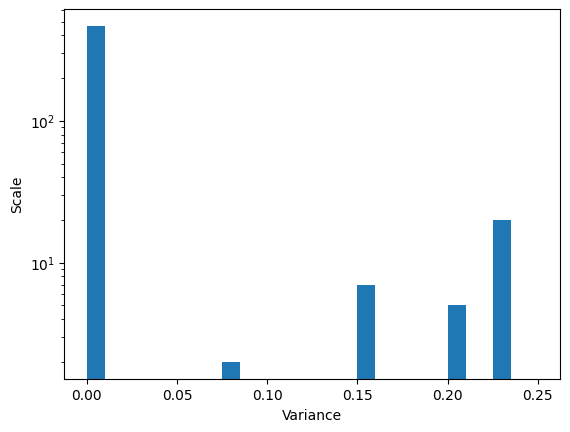

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def generate_credit_data(n_samples=1000, n_features=10, random_state=42):
	"""Generuje syntetyczne dane kredytowe."""
	X, y = make_classification(
		n_samples=n_samples, n_features=n_features,
		n_informative=6, n_redundant=2, n_clusters_per_class=2,
		random_state=random_state
	)
	return X, y

def train_single_trees(X_train, y_train, n_trees=10):
	"""Trenuje n pojedynczych drzew z roznymi seedami."""
	trees = []
	for seed in range(n_trees):
		tree = DecisionTreeClassifier(random_state=seed)
		tree.fit(X_train, y_train)
		trees.append(tree)
	return trees

def calculate_prediction_variance(trees, X):
    """Oblicza wariancje predykcji miedzy drzewami."""
    predictions = []
    
    for tree in trees:
        pred = tree.predict_proba(X)
        predictions.append(pred[:, 1])
        
    predictions = np.array(predictions)
    variance = np.var(predictions, axis=0)
    return variance

X, y = generate_credit_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

trees = train_single_trees(X_train, y_train)
var = calculate_prediction_variance(trees, X_test)

plt.hist(var, width=0.01, log=True)
plt.xlabel('Variance')
plt.ylabel('Scale')
plt.show()

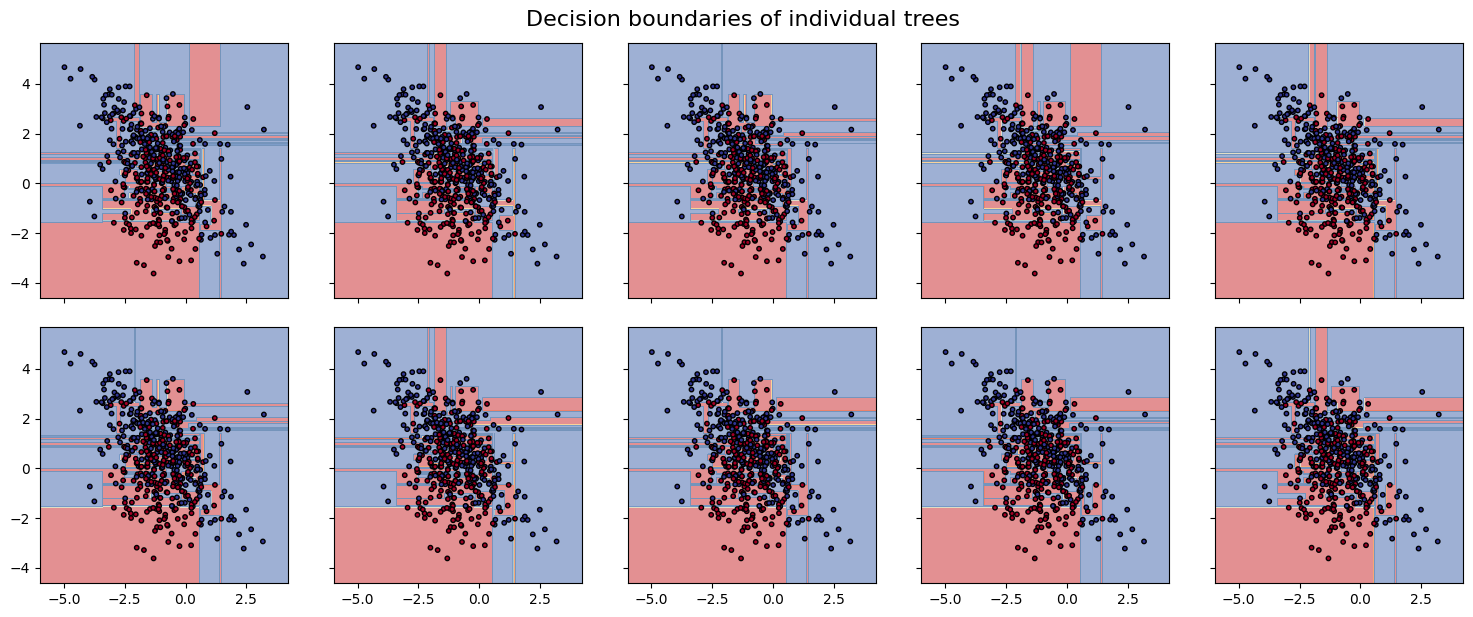

In [2]:
def visualize_decision_boundary(tree, X, y, ax, width=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, width),
                         np.arange(y_min, y_max, width))
    
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.5, cmap='RdYlBu')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolor='k', s=10)
    return ax.figure

plt.close('all')
fig, axarr = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
fig.tight_layout()

for seed, ax in enumerate(axarr.ravel()):
    tree = DecisionTreeClassifier(random_state=seed)
    tree.fit(X_train[:, :2], y_train)

    visualize_decision_boundary(tree, X_train[:, :2], y_train, ax)

fig.suptitle('Decision boundaries of individual trees', fontsize=16, y=1.02)
plt.show()

In [3]:
from scipy.stats import mode

def bootstrap_sample(X, y, random_state=None):
	"""Losuje probke bootstrap (n probek ze zwracaniem z n)."""
	rng = np.random.RandomState(random_state)
	n = len(X)
	indices = rng.choice(n, size=n, replace=True)
	oob_indices = list(set(range(n)) - set(indices))
	return X[indices], y[indices], oob_indices

def ensemble_train(X, y, random_state, n_trees=50, max_features=None):
    trees = []
    oob_indices_list = []
    for seed in range(n_trees):
        X_sample, y_sample, oob_indices = bootstrap_sample(X, y, random_state=random_state+seed)
        tree = DecisionTreeClassifier(random_state=random_state+seed, max_features=max_features)
        tree.fit(X_sample, y_sample)
        trees.append(tree)
        oob_indices_list.append(oob_indices)
    return trees, oob_indices_list

def ensemble_predict(trees, X):
    """Agreguje predykcje wielu drzew przez glosowanie wiekszosciowe."""
    predictions = []
    
    for tree in trees:
        pred = tree.predict(X)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    majority_vote, _ = mode(predictions, axis=0)
    return majority_vote

In [4]:
def train_randomized_trees(X, y, n_trees=10):
    trees = []
    for seed in range(n_trees):
        tree = DecisionTreeClassifier(max_features='sqrt', random_state=seed)
        tree.fit(X, y)
        trees.append(tree)
    return trees

def calculate_prediction_corrcoef(trees, X):
    predictions = []
    
    for tree in trees:
        pred = tree.predict_proba(X)
        predictions.append(pred[:, 1])
        
    predictions = np.array(predictions)
    n_trees = predictions.shape[0]
    
    corr_matrix = np.corrcoef(predictions)
    upper_tri_indices = np.triu_indices(n_trees, k=1)
    corr_values = corr_matrix[upper_tri_indices]
    
    return corr_values

plain_trees = train_single_trees(X_train, y_train, n_trees=50)
randomized_trees = train_randomized_trees(X_train, y_train, n_trees=50)

plain_var = calculate_prediction_variance(plain_trees, X_test)
randomized_var = calculate_prediction_variance(randomized_trees, X_test)

print(f'Average variance of plain trees: {np.mean(plain_var):.4f}')
print(f'Average variance of randomized trees: {np.mean(randomized_var):.4f}')

plain_corr = calculate_prediction_corrcoef(plain_trees, X_test)
randomized_corr = calculate_prediction_corrcoef(randomized_trees, X_test)

print(f'Average correlation of plain trees: {np.mean(plain_corr):.4f}')
print(f'Average correlation of randomized trees: {np.mean(randomized_corr):.4f}')

Average variance of plain trees: 0.0156
Average variance of randomized trees: 0.1050
Average correlation of plain trees: 0.9360
Average correlation of randomized trees: 0.5719


/home/notuser/.pyenv/versions/workspace/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


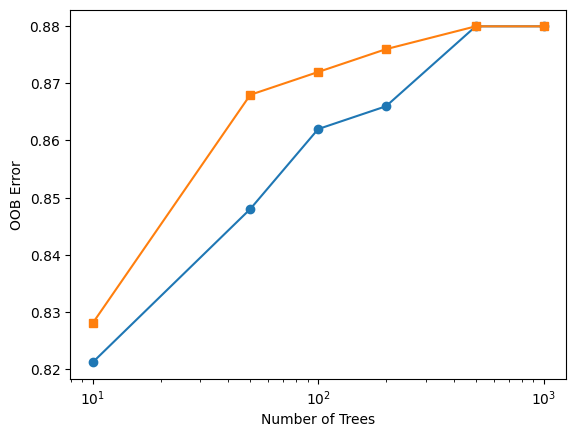

In [6]:
from sklearn.ensemble import RandomForestClassifier

def calculate_oob_error(X, y, trees, oob_indices_list):
    """Oblicza OOB error bez zbioru walidacyjnego."""
    n_samples = X.shape[0]
    preds_for_point = [[] for _ in range(n_samples)]

    for tree, idx in zip(trees, oob_indices_list):
        if not idx:
            continue
        
        preds  = tree.predict(X[idx])
        
        for i, pred in enumerate(preds):
            preds_for_point[idx[i]].append(pred)
            
    miss = total = 0
    
    for i in range(n_samples):
        if preds_for_point[i]:
            total += 1
            majority_vote, _ = mode(preds_for_point[i])
            if majority_vote != y[i]:
                miss += 1

    return 1 - miss / total

ensemble_errors = []
n_trees_list = [10, 50, 100, 200, 500, 1000]

for n_trees in n_trees_list:
    trees, oob_indices_list = ensemble_train(X_train, y_train, random_state=42, n_trees=n_trees, max_features='sqrt')
    oob_error = calculate_oob_error(X_train, y_train, trees, oob_indices_list)
    ensemble_errors.append(oob_error)

rf_errors = []

for n_trees in n_trees_list:
    rf = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt', oob_score=True, random_state=42)
    rf.fit(X_train, y_train)
    rf_errors.append(rf.oob_score_)

plt.plot(n_trees_list, ensemble_errors, marker='o')
plt.plot(n_trees_list, rf_errors, marker='s')
plt.xscale('log')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
plt.show()